In [1]:
# ! pip install kuzu

import kuzu

db = kuzu.Database("./final_db",read_only=True)
conn = kuzu.Connection(db)

In [8]:
def delete_node(name):
    response = conn.execute(
        """
        MATCH (u) WHERE u.name = $name DETACH DELETE u;
        """
        , {"name" : name})
    print(response.get_as_df())

delete_node("BLTA")

Empty DataFrame
Columns: []
Index: []


In [5]:
def delete_relationship(recipe, ingredient):
    response = conn.execute(
        """
        MATCH (u:Recipe)-[f]->(u1:Ingredient)
        WHERE u.name = $recipe AND u1.name = $ingredient
        DELETE f;
        """
        , {"recipe" : recipe, "ingredient": ingredient})
    print(response.get_as_df())

delete_relationship("blta", "sour_cream")

Empty DataFrame
Columns: []
Index: []


In [3]:
# based on recipe what other recipes have the most similar ingredients
# TODO

def find_similar_recipes(name):
    response = conn.execute(
        """
        MATCH (n:Ingredient)-[r:UsedIn]->(m:Recipe)
        WHERE n.name = $name 
        RETURN m.name, m.type;
        """
        , {"name" : name})
    print(response.get_as_df())
    
    
find_similar_recipes("chicken_breast")

                       m.name    m.type
0  korean_chicken_sandwhiches  sandwich
1       chinese_chicken_salad     salad
2            chicken_teriyaki      bowl


In [4]:
recipe_dict = {"name" : "chicken_teriyaki", "display_name": "Chicken Teriyaki", "type": "bowl"}

ingredient_dict = [{"name" : "teriyaki", "display_name": "teriyaki", "type": "packaged"}]

relationship = {"quantity" : "1", "label": 'bottle'}

In [9]:
def find_node(name):
    response = conn.execute(
        """
        MATCH (n)
        WHERE n.name = $name
        RETURN *
        """
        , {"name" : name})
    print(response.get_as_df())
    
    
find_node("BLTA")

Empty DataFrame
Columns: [n]
Index: []


In [12]:
def insert_recipe(name, display_name, type):
    conn.execute(
        """
        CREATE (u:Recipe {name : $name, display_name: $display_name, type: $type});
        """
        , {"name" : name, "display_name": display_name, "type": type})
    
    print("done")
insert_recipe("chicken_teriyaki", "Chicken Teriyaki", "bowl")

done


In [18]:
def insert_ingredient(name, display_name, type):
    conn.execute(
        """
        CREATE (u:Ingredient {name : $name, display_name: $display_name, type: $type});
        """
        , {"name" : name, "display_name": display_name, "type": type})
    print("done")

insert_ingredient("teriyaki", "teriyaki", "packaged")

done


In [30]:
def create_relationship(recipe_name, ingredient_name, qty, label):

    # qty = {quantity : xx, label : xx}

    conn.execute(
        """
        MATCH (u1:Recipe), (u2:Ingredient)
        WHERE u1.name = $recipe_name AND u2.name = $ingredient_name
        CREATE (u1)-[r:Contains {quantity: $qty, label: $label}]->(u2)
        RETURN r;
        """,
        {"recipe_name": recipe_name, "ingredient_name": ingredient_name, "qty": qty, "label":label}
    )
    print("done")

create_relationship("chicken_teriyaki", "chicken_breast", "1", "pack")

done


In [6]:
def find_edge(recipe):
    response = conn.execute(
        """
        MATCH (n:Recipe)-[r:Contains]->(m:Ingredient)
        WHERE n.name = $name
        RETURN m.name, n.name, r.quantity;
        """, {"name" : recipe})
    
    print(response.get_as_df())

find_edge("blta")

Empty DataFrame
Columns: [m.name, n.name, r.quantity]
Index: []


In [5]:
from graph import list_recipes

list_recipes()

,n.name,n.display_name
0,surf_turf,Surf & Turf
1,korean_chicken_sandwhiches,Korean Chicken Sandwiches
2,sausage_risotto,Sausage Risotto
3,cherry_tomato_pasta,Cherry Tomato Pasta
4,salmon_bowl,Salmon Bowl
5,taco_bowl,Taco Bowl
6,curry,Curry
7,quinoa,Quinoa
8,vodka_pasta,Vodka Pasta
9,turkey_burger,Turkey Burger


In [3]:
# conn.execute("CREATE NODE TABLE Ingredient(name STRING, display_name STRING, type STRING, PRIMARY KEY (name))")
# conn.execute("CREATE NODE TABLE Recipe(name STRING, display_name STRING, type STRING, PRIMARY KEY (name))")
# conn.execute("CREATE REL TABLE Contains(FROM Recipe TO Ingredient, quantity STRING, label STRING)")
# conn.execute("CREATE REL TABLE UsedIn(FROM Ingredient TO Recipe, quantity STRING, label STRING)")

In [4]:
# conn.execute('COPY Ingredient FROM "bulk_data/ingredients3.csv"')
# conn.execute('COPY Recipe FROM "bulk_data/recipe2.csv"')
# conn.execute('COPY Contains FROM "bulk_data/contains2.csv"')
# conn.execute('COPY UsedIn FROM "bulk_data/usedIn.csv"')


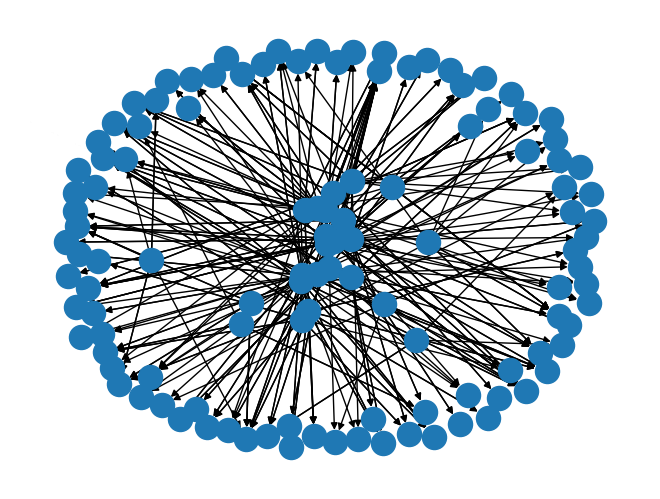

In [3]:
import networkx as nx

response = conn.execute(
        """
        MATCH (n)-[r:Contains]-(m)
        RETURN *
        
        """
    )

# print(response.get_as_df())


G = response.get_as_networkx(directed=True)
# while response.has_next():
#     print(response.get_next())

nx.draw(G,with_labels=0)

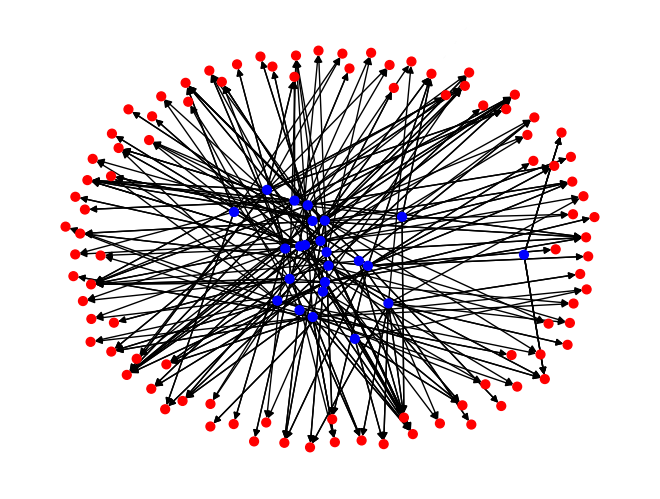

In [4]:
colors = ['red' if G.nodes[node]['_label'] == 'Ingredient' else 'blue' for node in list(G.nodes())]
nx.draw_spring(G, node_color=colors, node_size=40)

In [5]:
# ! pip install yfiles-jupyter-graphs
from yfiles_jupyter_graphs import GraphWidget


from typing import Union, Any

def custom_node_color_mapping(node: dict[str, Any]):
    """let the color be orange or blue if the index is even or odd respectively"""
    return ("#eb4934" if node['properties']['_label'] == "Recipe" else "#2456d4")

w = GraphWidget(graph=G)
w.set_sidebar(enabled=False)
w.set_node_color_mapping(custom_node_color_mapping)
display(w)

GraphWidget(layout=Layout(height='800px', width='100%'))

In [20]:
# list recipes
def list_recipes():
    response = conn.execute(
            """
            MATCH (n:Recipe)
            RETURN n.name
            """
        )
    list = []
    while response.has_next():
        # print(response.get_next())
        list.append(response.get_next()[0])

    return list
list_recipes()

['surf_turf',
 'korean_chicken_sandwhiches',
 'sausage_risotto',
 'cherry_tomato_pasta',
 'salmon_bowl',
 'taco_bowl',
 'curry',
 'quinoa',
 'vodka_pasta',
 'turkey_burger',
 'italian_bean_soup',
 'bone_broth_soup',
 'mediterranean_bowl',
 'caesar_salad',
 'short_rib_bowl',
 'bolognese',
 'steak_salad',
 'chinese_chicken_salad',
 'caprese_sandwich',
 'BLTA',
 'steak_potato',
 'chili',
 'tomato_soup',
 'chicken_teriyaki',
 'grilled_cheese']

In [23]:
# list single recipe
import pandas as pd
def get_recipe(recipeName):

    response = conn.execute(
                f"""
                MATCH (n:Ingredient)-[r:UsedIn]->(m:Recipe)
                WHERE m.name = '{recipeName}'
                RETURN n.name, r.quantity
                """
            )
    list = []
    while response.has_next():
        # print(response.get_next())
        list.append(response.get_next())

    return pd.DataFrame(list, columns=['Ingredient', 'Quantity'])

In [158]:
# get each recipes ingredients
df1 = get_recipe("sausage_risotto")
df2 = get_recipe("short_rib_bowl")
df3 = get_recipe("salmon_bowl")
df4 = get_recipe("caprese_sandwich")
df5 = get_recipe("vodka_pasta")

In [166]:
# join ingredients for each meal
ingredient_list = pd.concat([df1, df2, df3, df4, df5], axis=0)

In [174]:
# number of recipes that need this ingredient
ingredient_list.groupby("Ingredient")["Quantity"].count()

Ingredient
balsamic_vinegar    1
bone_broth          1
calabrian_chilis    1
chicken_sausage     1
cucumber            2
garlic              2
heavy_cream         1
jalapeno            1
kimchi              2
lemon               2
mozerrella          1
olive_oil           1
orzo                1
pasta               1
red_onion           1
rice                3
salmon              1
short_ribs          1
sourdough           1
soy_sauce           1
spinach             1
tomato              1
tomato_paste        1
Name: Quantity, dtype: int64

In [170]:
# split ingredient
pd.concat([ingredient_list, ingredient_list['Quantity'].str.split('_', expand=True)], axis=1).drop(columns=['Quantity'])

,Ingredient,0,1
0,soy_sauce,eyeball,None
1,chicken_sausage,1,pack
2,rice,2,cups
3,spinach,eyeball,None
4,garlic,eyeball,None
5,bone_broth,4,cups
6,lemon,eyeball,None
7,orzo,1,bag
0,kimchi,eyeball,None
1,rice,eyeball,None
